In [1]:
import os
import sys
path = '/Users/victorwei/Research projects/VQE_2022_summer/NEM_SU2/code'
sys.path.append(path)

import qiskit
import numpy as np
from qiskit.quantum_info import Statevector
import nqs_models
from exact_solvers import GenericExactState
import utils
import torch
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams["figure.dpi"] = 200

In [2]:
import Helper_fun as helper
import ShadowTomographyTrainer_sum as shadow_trainer

In [3]:
# now we write function that will measure in random Clifford circuits
def random_Clifford_shadow(circuit, num_shadow):
    
    N = circuit.num_qubits
    
    rng = np.random.default_rng(1717)
    cliffords = [qiskit.quantum_info.random_clifford(N, seed=rng) for _ in range(num_shadow)]

    results = []
    for cliff in cliffords:
        qc_c  = circuit.compose(cliff.to_circuit())

        counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(1)
        results.append(counts)
        
    return cliffords, results

In [4]:
from qiskit.circuit.library import TwoLocal
N = 6
num_sites = N
state_ = np.zeros(2**N, dtype = 'complex128')

size_ = 7
rand_basis = np.random.randint(2**N, size = size_)
rand_norm = np.random.rand(size_)
rand_phase = np.random.rand(size_) * 2 * np.pi

for i in range(7):
    state_[rand_basis[i]] = rand_norm[i] * np.exp(1j * rand_phase[i])

print(state_)
print(rand_basis)
test_state_dense = state_ / np.sqrt( np.sum( np.abs(state_)**2 ) )
state = Statevector(test_state_dense )

qc = qiskit.QuantumCircuit( N )

qc.initialize(state)

def decomp_cir(cir, n):
    for i in range(n):
        cir = cir.decompose()
    return cir

test_circuit = decomp_cir(qc, 10)
#print(qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose())
print(test_circuit)

[ 0.        +0.j         -0.98582783-0.02200188j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.10806195-0.74855149j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         -0.11724451+0.18592021j  0.        +0.j
 -0.87462354-0.4474583j   0.        +0.j         -0.06895627-0.24041431j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.52438458+0.37778385j -0.15341854-0.21514182j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.     

In [5]:
# we set up the shadow_trainer inputs, first the nqs model
num_sites = N

nqs_transformer_1 = nqs_models.TransformerWF(num_sites = num_sites,
                                            num_layers=2,
                                            internal_dimension=8,
                                            num_heads=4,
                                            dropout=0.0)
nqs_model_ = nqs_transformer_1

In [6]:
# neural quantum state parameters
max_iters_=1000
nqst_lr=1e-2
batch_size_=100
num_samples_ = 5000
K_ = 1
#chunk_size_ = 50

log_every_ = 1
eval_every_ = 1
logging_callbacks_ = []
eval_callbacks_ = []

target_state_ = GenericExactState( utils.Complex(test_state_dense) )


optimizer_ = torch.optim.Adam(nqs_model_.parameters(), lr=nqst_lr)
optimizer_sgd = torch.optim.SGD(nqs_model_.parameters(), lr=nqst_lr)

In [7]:
# now we collect classical shadows
cliffords_, results_ = helper.random_Clifford_shadow(test_circuit, num_shadow=100)

In [8]:
shadow_trainer_driver = shadow_trainer.ShadowTomographyTrainer(
                    nqs_model = nqs_model_,
                    #cliffords = cliffords_,
                    #results = results_,
                    circuit = test_circuit,
                    optimizer = optimizer_,
                    batch_size = batch_size_,
                    logging_callbacks = logging_callbacks_,
                    eval_callbacks = eval_callbacks_,
                    log_every = log_every_,
                    eval_every = eval_every_,
                    target_state = target_state_,
                    max_iters = max_iters_,
                    num_samples = num_samples_,
                    K = K_)
                    #chunk_size = chunk_size_)

In [9]:
loss_vmc, cost_vmc = shadow_trainer_driver.train()

Iteration 0
Cost function is 1.0727341569052713
Exact infidelity is 0.9797610559577402
Iteration 1
Cost function is 0.815679038705815
Exact infidelity is 0.9775071851981443
Iteration 2
Cost function is 1.0776341275100128
Exact infidelity is 0.9788148044254761
Iteration 3
Cost function is 1.041301610106419
Exact infidelity is 0.9816628300518563
Iteration 4
Cost function is 1.0083623928637644
Exact infidelity is 0.9823516164604942
Iteration 5
Cost function is 1.0242222495252105
Exact infidelity is 0.9824602598579524
Iteration 6
Cost function is 0.8434140926332367
Exact infidelity is 0.9841422878365497
Iteration 7
Cost function is 0.8631209587116255
Exact infidelity is 0.9831243390646055
Iteration 8
Cost function is 1.1093428467103186
Exact infidelity is 0.9800451675486889
Iteration 9
Cost function is 0.8335126236539344
Exact infidelity is 0.9770175108406415
Iteration 10
Cost function is 0.8299240433779264
Exact infidelity is 0.9730484711062766
Iteration 11
Cost function is 1.065941925175

KeyboardInterrupt: 

(-0.05, 0.1)

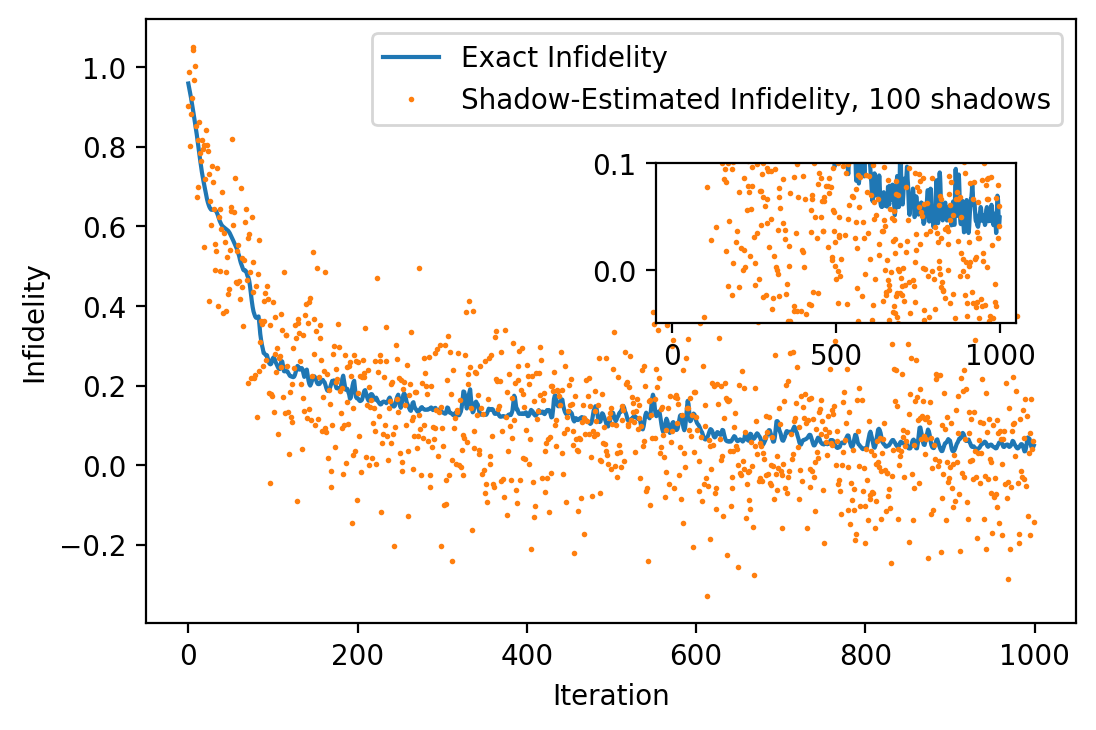

In [52]:
iters = np.linspace(0,len(loss_vmc)-1, len(loss_vmc))
ax1 = plt.axes() # standard axes
ax2 = plt.axes([0.55, 0.5, 0.3, 0.2])

ax1.plot(iters, loss_vmc, label = 'Exact Infidelity')
ax1.plot(iters, cost_vmc, '.', label = 'Shadow-Estimated Infidelity, 100 shadows',markersize=2)
#plt.ylim(-0.1,0.2)
ax1.legend()
ax1.set_ylabel('Infidelity')
ax1.set_xlabel('Iteration')

ax2.plot(iters, loss_vmc, label = 'Exact Infidelity')
ax2.plot(iters, cost_vmc, '.', label = 'Shadow-Estimated Infidelity, 100 shadows',markersize=2)
ax2.set_ylim(-0.05,0.1)

In [34]:
old_loss_vmc = loss_vmc
old_cost_vmc = cost_vmc

In [43]:
# let's reproduce the problem here
print(nqs_model_.amplitudes(unique_samples[0]))

real: -0.09714684635400772 imag: 0.31132885813713074


In [10]:
NN_samples = nqs_model_.sample(1)
unique_samples, counts = torch.unique(NN_samples, dim=0, return_counts=True)

In [12]:
unique_samples_new = helper.torch_delete(unique_samples, 0)

In [13]:
print(unique_samples_new)

tensor([], size=(0, 4), dtype=torch.uint8)


In [15]:
print(counts)

tensor([1])


In [19]:
Clifford_sample_log_amplitudes, weights_new, unique_samples_new = helper.samples_to_log_clifford_amplitudes(np.zeros(2**4), unique_samples, counts) 

In [48]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

cliffords_chunked = chunker(cliffords_, 10)

In [34]:
print(len(cliffords_chunked))

TypeError: object of type 'generator' has no len()

In [49]:
for i in cliffords_chunked:
    print(len(i))

10
10
10


In [10]:
nqs_model_.share_memory()

TransformerWF(
  (embedder): Embedding(2, 8)
  (pos_encoder): LearnedPositionalEncoding()
  (transformer): Transformer(
    (layers): ModuleList(
      (0): TransformerLayer(
        (attn): GTrXLLayerWrapper(
          (layernorm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (layer): MultiHeadSelfAttention(
            (qvk_net): Linear(in_features=8, out_features=24, bias=False)
            (o_net): Linear(in_features=8, out_features=8, bias=False)
          )
        )
        (fc): GTrXLLayerWrapper(
          (layernorm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (layer): FCLayer(
            (net): Sequential(
              (0): Linear(in_features=8, out_features=8, bias=True)
            )
          )
        )
      )
      (1): TransformerLayer(
        (attn): GTrXLLayerWrapper(
          (layernorm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (layer): MultiHeadSelfAttention(
            (qvk_net): Linear(in_features=8,

In [13]:
a = torch.tensor([2.,3.], requires_grad = True)
b = torch.tensor([6.,4.], requires_grad = True)
Q = 3*a**3 - b**2
#Q.backward()

print(Q.grad_fn)

In [11]:
import random
print(random.sample(cliffords_, 2) )

[Clifford(StabilizerTable(
array([[ True, False,  True,  True,  True,  True,  True,  True],
       [ True, False, False,  True,  True,  True,  True, False],
       [False,  True, False,  True,  True,  True,  True, False],
       [False, False,  True,  True, False, False,  True,  True],
       [ True,  True, False,  True,  True,  True, False,  True],
       [False, False, False, False, False,  True,  True,  True],
       [ True, False,  True,  True,  True, False,  True,  True],
       [ True, False, False, False, False, False, False,  True]]),
phase=array([ True,  True,  True,  True,  True, False,  True, False]))), Clifford(StabilizerTable(
array([[ True,  True, False,  True, False, False, False, False],
       [False, False, False, False, False,  True, False,  True],
       [ True, False,  True, False, False,  True,  True,  True],
       [False,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True, False, False,  True,  True],
       [False,  True, False

In [34]:
import pickle
data = np.array(cliffords_)
pickle.dump(data,open('Shadows/file.pkl','wb'))
loaded_data = np.load("Shadows/file.pkl")
print('Loaded data:',loaded_data)

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [37]:
np.save('Shadows/cliffords_5000', np.array(cliffords_), allow_pickle=True )

In [38]:
a = np.load('Shadows/cliffords_5000',allow_pickle=True,fix_imports=True)
print(a)

OSError: Failed to interpret file 'Shadows/cliffords_5000' as a pickle

In [41]:
print(np.array(cliffords_)[0])

[[-0.25+0.25j  0.25+0.25j  0.  +0.j    0.  +0.j    0.25-0.25j  0.25+0.25j
   0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j    0.25+0.25j -0.25+0.25j
   0.  +0.j    0.  +0.j    0.25+0.25j  0.25-0.25j]
 [ 0.25+0.25j -0.25+0.25j  0.  +0.j    0.  +0.j    0.25+0.25j  0.25-0.25j
   0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j    0.25-0.25j -0.25-0.25j
   0.  +0.j    0.  +0.j   -0.25+0.25j -0.25-0.25j]
 [ 0.  +0.j    0.  +0.j   -0.25-0.25j  0.25-0.25j  0.  +0.j    0.  +0.j
  -0.25-0.25j -0.25+0.25j  0.25-0.25j -0.25-0.25j  0.  +0.j    0.  +0.j
  -0.25+0.25j -0.25-0.25j  0.  +0.j    0.  +0.j  ]
 [ 0.  +0.j    0.  +0.j    0.25-0.25j -0.25-0.25j  0.  +0.j    0.  +0.j
  -0.25+0.25j -0.25-0.25j  0.25+0.25j -0.25+0.25j  0.  +0.j    0.  +0.j
   0.25+0.25j  0.25-0.25j  0.  +0.j    0.  +0.j  ]
 [ 0.  +0.j    0.  +0.j    0.25+0.25j  0.25-0.25j  0.  +0.j    0.  +0.j
   0.25+0.25j -0.25+0.25j  0.25-0.25j  0.25+0.25j  0.  +0.j    0.  +0.j
  -0.25+0.25j  0.25+0.25j  0.  +0.j    0.  +0.j  ]
 [ 0.  +0.j    0.

In [8]:
print(test_circuit.num_qubits)

4
